# Starting EDA of pH project

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import Counter
from sklearn.linear_model import LinearRegression

In [3]:
csv_file = "../Data/R12-over-10-copies.csv"
df = pd.read_csv(csv_file)
df.head()

,Sequence,Count
0,AGTGCCATCGTGCGTATCCTTCACTCCTTGCTCGACAAGAAGCGAA...,91
1,AGTGCCATCGTGCGTATCCTTCACGTTTGTTCTACAAAAGCGAAGC...,86
2,AGTGCCATCGTGCGTATCCTGAACATTGACGTGTAGTCAATGCGAA...,83
3,AGTGCCATCGTGCGTATCCCGCTCCGCTAATATCTATGTTAGCGAA...,80
4,AGTGCCATCGTGCGTATCCTGAACATAGACGTTTAGTCTATGCGAA...,78


In [4]:
df.shape

(10383, 2)

In [5]:
sum(df.iloc[:, 0].isnull())

0

In [6]:
sum(df.iloc[:, 1].isnull())

0

In [7]:
df.dtypes

Sequence    object
Count        int64
dtype: object

In [8]:
# check base type proportions
def base_count(text):
    return dict(Counter(text))   

In [9]:
df['Base Counts'] = df['Sequence'].apply(base_count)
# df['Base Counts'][1]['A']
df['A'] = df['Base Counts'].astype(object).apply(lambda x: x.get('A', np.nan))
df['C'] = df['Base Counts'].astype(object).apply(lambda x: x.get('C', np.nan))
df['T'] = df['Base Counts'].astype(object).apply(lambda x: x.get('G', np.nan))
df['G'] = df['Base Counts'].astype(object).apply(lambda x: x.get('T', np.nan))

In [10]:
df.head().iloc[:, 3:]

,A,C,T,G
0,24,26,26,22
1,22,27,29,20
2,23,23,29,23
3,24,25,28,21
4,24,21,30,23


In [11]:
df['Length'] = df['Sequence'].apply(len)

In [12]:
sum((np.sum(df[['A', 'C', 'T', 'G']], axis=1) == df['Length']).isnull()) # Checks base counts add up to length of sequence

0

In [13]:
allowed_keys = {'A', 'C', 'T', 'G'} # Checks that there are no weird nonstandard bases
df['Nonstandard base'] = df['Base Counts'].astype(object).apply(lambda x: not set(x.keys()).issubset(allowed_keys))
np.sum(df['Nonstandard base'])

0

In [14]:
df.head()

,Sequence,Count,Base Counts,A,C,T,G,Length,Nonstandard base
0,AGTGCCATCGTGCGTATCCTTCACTCCTTGCTCGACAAGAAGCGAA...,91,"{'A': 24, 'G': 26, 'T': 22, 'C': 26}",24,26,26,22,98,False
1,AGTGCCATCGTGCGTATCCTTCACGTTTGTTCTACAAAAGCGAAGC...,86,"{'A': 22, 'G': 29, 'T': 20, 'C': 27}",22,27,29,20,98,False
2,AGTGCCATCGTGCGTATCCTGAACATTGACGTGTAGTCAATGCGAA...,83,"{'A': 23, 'G': 29, 'T': 23, 'C': 23}",23,23,29,23,98,False
3,AGTGCCATCGTGCGTATCCCGCTCCGCTAATATCTATGTTAGCGAA...,80,"{'A': 24, 'G': 28, 'T': 21, 'C': 25}",24,25,28,21,98,False
4,AGTGCCATCGTGCGTATCCTGAACATAGACGTTTAGTCTATGCGAA...,78,"{'A': 24, 'G': 30, 'T': 23, 'C': 21}",24,21,30,23,98,False


In [15]:
df['Length'].value_counts().sort_values(ascending=False)

Length
98     9893
97      325
99       65
96       42
95       11
94        7
88        7
87        4
91        4
84        3
90        3
93        3
86        3
85        3
92        3
89        1
107       1
102       1
108       1
82        1
100       1
83        1
Name: count, dtype: int64

The sequences range in length from 82 to 108, but most commonly at 98.
As I recally, NGS clips the first few base pairs down from nominal 100 because of poor quality.
The other variants in sequence length are likely due to mutations from PCR errors.

In [16]:
v_df = df # Save a verbose version of df
df = df[['Sequence', 'Length', 'Count', 'A', 'C', 'T', 'G']]
df.head()

,Sequence,Length,Count,A,C,T,G
0,AGTGCCATCGTGCGTATCCTTCACTCCTTGCTCGACAAGAAGCGAA...,98,91,24,26,26,22
1,AGTGCCATCGTGCGTATCCTTCACGTTTGTTCTACAAAAGCGAAGC...,98,86,22,27,29,20
2,AGTGCCATCGTGCGTATCCTGAACATTGACGTGTAGTCAATGCGAA...,98,83,23,23,29,23
3,AGTGCCATCGTGCGTATCCCGCTCCGCTAATATCTATGTTAGCGAA...,98,80,24,25,28,21
4,AGTGCCATCGTGCGTATCCTGAACATAGACGTTTAGTCTATGCGAA...,98,78,24,21,30,23


In [17]:
for col in ['A', 'C', 'T', 'G']:
    df.loc[:, col] = df[col]/df['Length']

In [18]:
df.head()

,Sequence,Length,Count,A,C,T,G
0,AGTGCCATCGTGCGTATCCTTCACTCCTTGCTCGACAAGAAGCGAA...,98,91,0.244898,0.265306,0.265306,0.224490
1,AGTGCCATCGTGCGTATCCTTCACGTTTGTTCTACAAAAGCGAAGC...,98,86,0.224490,0.275510,0.295918,0.204082
2,AGTGCCATCGTGCGTATCCTGAACATTGACGTGTAGTCAATGCGAA...,98,83,0.234694,0.234694,0.295918,0.234694
3,AGTGCCATCGTGCGTATCCCGCTCCGCTAATATCTATGTTAGCGAA...,98,80,0.244898,0.255102,0.285714,0.214286
4,AGTGCCATCGTGCGTATCCTGAACATAGACGTTTAGTCTATGCGAA...,98,78,0.244898,0.214286,0.306122,0.234694


In [19]:
df['Count'].describe()

count    10383.000000
mean        14.926900
std          6.640851
min         10.000000
25%         11.000000
50%         13.000000
75%         16.000000
max         91.000000
Name: Count, dtype: float64

### Examine the relationship between frequency and base percentage.
Plot Count vs Base percentage.  See if there is a relationship.

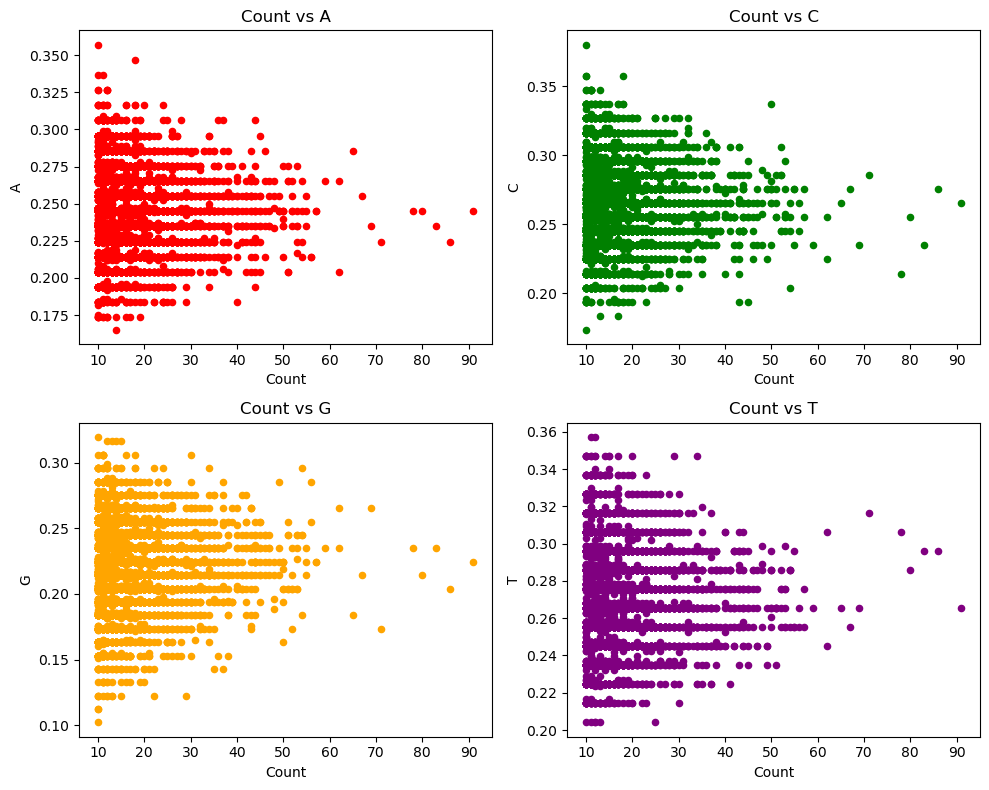

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(10,8))

df.plot(kind='scatter', x='Count', y='A', ax=axes[0, 0], title='Count vs A', color='red')
df.plot(kind='scatter', x='Count', y='C', ax=axes[0, 1], title='Count vs C', color='green')
df.plot(kind='scatter', x='Count', y='G', ax=axes[1, 0], title='Count vs G', color='orange')
df.plot(kind='scatter', x='Count', y='T', ax=axes[1, 1], title='Count vs T', color='purple')

plt.tight_layout()
plt.show()

In [ ]:
# HERE
# make histogram and then examine relationships

### Examine the relationship between count and variance of base content.
#### By construction, higher copy numbers of a sequence means that there's less variance.  Whereas, low copy numbers of each sequence means there is naturally going to be much greater variation.

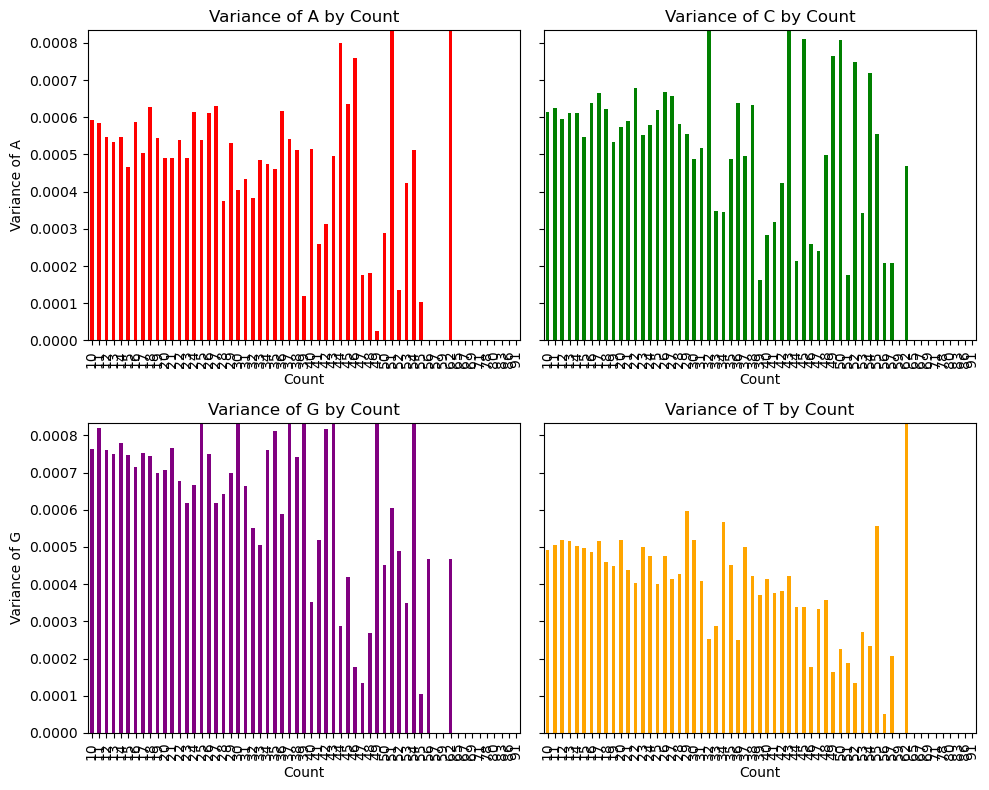

In [101]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)

# Compute global max variance for consistency
max_variance = max(df[col].var() for col in base_columns)

for col, ax in zip(base_columns, axes.flatten()):
    grouped_variance = df.groupby('Count')[col].var()
    grouped_variance.plot(kind='bar', ax=ax, color=base_colors[col])
    ax.set_title(f'Variance of {col} by Count')
    ax.set_xlabel('Count')
    ax.set_ylabel(f'Variance of {col}')
    ax.set_ylim(0, max_variance * 1.1)
    
plt.tight_layout()
plt.show()